# Challenge 1 - Getting started <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">

Welcome to the 2020 NextWave Data Science Challenge!

This notebook will show you how to open and explore the data, identify problematic areas of the data, create a basic solution to the problem, and submit your results via the EY Data Science platform.

Prior to running this notebook, make sure you have:
* **Created a profile** on the [EY Data Science Platform](https://datascience.ey.com/)
* **Registered** for "NextWave Data Science Challenge 1" on the Platform

We also recommend checking out the resources in the "01_Beginners_guide" folder to learn about jupyter notebooks and the Open Data Cube before coming back here.

### Your task

The training dataset contains 129 linescan images (infra-red images taken from an airplane) of bushfires in Victoria, Australia, during the first three months of 2019. There are also polygons showing where the fire is in each image, which have been hand-drawn by our collaborators at the Country Fire Authority (CFA). These polygons are the ground truth your solution should be able to recreate.

There are an additional 5 linescan images, the test dataset, where the polygons showing the fire boundaries have not been provided. Your task is to train a model or process which can produce a fire boundary for the remaining 5 linescans with no polygon.

All the linescan images (both the traning and test sets) are served via the Open Data Cube python library. The polygons are already available in your environment.

### Import libraries and instantiate a datacube

In [43]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

from datacube import Datacube
import rasterio
import matplotlib.pyplot as plt

from skimage import io
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage import measure

from affine import Affine
from rasterio.plot import show, show_hist

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

In [44]:
dc = Datacube(app="Getting started")

## Import variables
### Import input variable: aerial linescan images

Firstly, let's query the datacube object to identify what linescans are available. We'll also sort them by ID to ensure they're ordered consistently for this guide.

In [45]:
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))

sample = linescan_datasets[0]

print(sample)
print(sample.metadata_doc['label'])

print(f'\nNumber of linescan datasets: {len(linescan_datasets)}')

Dataset <id=5526d747-c6b7-50b8-b0b5-905ca28264ee product=linescan location=https://geoau.blob.core.windows.net/ey-gsa/linescan/ROSEDALE_P1_201901041439_MGA94_55.odc-dataset.json>
ROSEDALE_P1_201901041439_MGA94_55

Number of linescan datasets: 134


The results stored in `linescan_datasets` are metadata which describe the various linescan files, including the filename (called the 'label'), extent, date and time of acquisition, and an ID number for that dataset.  Not until we load the dataset can we actually read or view the data. The cell below loads a single linescan from the available list.

In [59]:
ds = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))
print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 1171, y: 777)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-25T22:55:00
  * y            (y) float64 5.833e+06 5.833e+06 ... 5.826e+06 5.826e+06
  * x            (x) float64 4.258e+05 4.258e+05 ... 4.375e+05 4.375e+05
    spatial_ref  int32 28355
Data variables:
    linescan     (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:28355
    grid_mapping:  spatial_ref


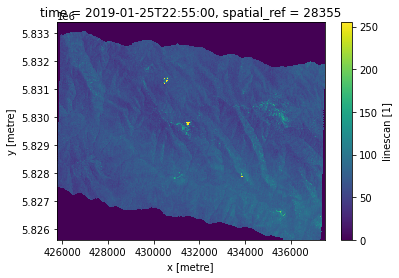

In [60]:
ds.linescan.plot()

The 'challenge1_train.csv' file lists the names of all the training linescans that are available.

In [48]:
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')
print(train.head())
print(f'\nNumber of training images: {len(train)}')

                               filename     DateTimeLocal       DateTimeUTC
id                                                                         
0     ROSEDALE_P1_201901041439_MGA94_55   4/01/2019 14:39    4/01/2019 3:39
1   ROSEDALE_1_P1_201901041446_MGA94_55   4/01/2019 14:46    4/01/2019 3:46
2   ROSEDALE_3_P1_201901041501_MGA94_55   4/01/2019 15:01    4/01/2019 4:01
3   POINT_H_62_P1_201901162128_MGA94_55  16/01/2019 21:28  16/01/2019 10:28
4   NUNNETT_73_P1_201901171134_MGA94_55  17/01/2019 11:34   17/01/2019 0:34

Number of training images: 129


### Import Target Variable: Fire Map Polygons

Let's load and display the dataset.

In [49]:
vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)
print('Number of objects in geodataframe: ' + str(len(gdf)))
gdf.head().T

Number of objects in geodataframe: 976


,0,1,2,3,4
Source,Linescan,Linescan,Linescan,Linescan,Linescan
SourceName,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg
Type,Initial ignition,Initial ignition,Initial ignition,Spot,Main run
dtString,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 17:50:00.000,2019/01/26 17:50:00.000
Comments,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 86 - Jericho - Thomson - Jo...,originally Latrobe 85 - Jericho - Cream Can Hill,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 87 - Jericho - Jim Track
dtUTC,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-26 06:50:00,2019-01-26 06:50:00
dtLocal,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 17:50:00,2019-01-26 17:50:00
ID,0,1,2,3,4
event,Latrobe86,Latrobe86,Latrobe86,Latrobe86,Latrobe86
geometry,"POLYGON ((431455.6047864075 5829806.836519156,...","POLYGON ((433874.4491466696 5827986.798174933,...","POLYGON ((430459.9135101112 5831285.491971598,...","POLYGON ((431937.3755649604 5829943.370969374,...","POLYGON ((431541.6507835893 5829804.025387563,..."


In [50]:
attribute_col = 'SourceName'
map_shapefile(gdf, attribute=attribute_col, fillOpacity=0.2, color="yellow", fillColor="red", default_zoom=8)

Label(value='')

Map(center=[-37.61040977368337, 146.4838196608676], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Exploring the Polygon Dataset
While the polygons provided were created from the linescan images, it is not always easy to see exactly which linescan was the source for a given polygon.

### Direct matches
Looking at the linescan dataset metadata, in many cases the linescan label field can be used to match the linescan to a set of polygons using the SourceName field, with some slight changes.

In [51]:
print(linescan_datasets[23].metadata_doc['label'])

ABERFELDY_WEST_200_P1_201901260955_MGA94_55


In [52]:
print(gdf.SourceName[0])

aberfeldy west 200 p1_201901260955_mga94_55.jpg


### Composite Polygons

Another subset of the polygon dataset that will require more careful consideration are polygons derived from multiple linescans. These polygons usually represent larger fires that stretch over many linescan images and are referred to as "composite polygons".

Identifying these polygons is a little trickier and involves searching the SourceName attribute for the word "composite". Some composites might not meet this condition, but will have a list of numbers representing the linescans it was derived from, so in addition to "composite", we will also search for commas and the amphersand symbol '&'. 

The query is as follows:


In [53]:
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]

print(f"Total composite polygons: {len(composites)}")
composites.SourceName.head()

Total composite polygons: 285


This pattern has match groups. To actually get the groups, use str.extract.


240    Composite wallhalla 397,398 & 401 20190225 (13...
241    Composite wallhalla 397,398 & 401 20190225 (13...
242    Composite wallhalla 397,398 & 401 20190225 (13...
315    macalister 681 & 682, (684 & 685 minor) compos...
316    macalister 681 & 682, (684 & 685 minor) compos...
Name: SourceName, dtype: object

Despite there being almost 300 composite polygons, there are only a few distinct SourceName values. You will find the SourceName contains valuable information for matching the polygon to its relevant linescans, such as the fire name, the linescan identifiers and the date and time range over which the polygon covers.

In [54]:
composites.SourceName.unique()

array(['Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)',
       'macalister 681 & 682, (684 & 685 minor) composite 0517-0539hrs',
       'composite macalister97 803, 806 &  807 1455-1532hrs',
       'macalister91 751, 752, 755, 760, 761 & 762 composite 1549-1730hrs',
       'macalister91 766,767 & 770 composite 1239-1314hrs',
       'macalister91 775, 776, 779 & 783 composite 1345-1643hrs',
       'macalister91 789, 790 & 793 composite 1330-1358hrs',
       'macalister91 804, 805 & 808 composite 1503-1539hrs',
       'macalister91 646,648 & 649 composite - 0440hrs to 0453hrs',
       'macalister 695,698 & 699 composite 1542 - 1610hrs',
       'macalister 696,697,700 - 1545-1613hrs',
       'Composite wallhalla 380 & 381 20190206 (1347 & 1356hrs)'],
      dtype=object)

### Cleaning Up Polygon Dataset

Let's work on the string formatting first. The format is slightly different between the linescan label field and the polygon SourceName field. The white spaces have been replaced with underscores and the '.jpg' at the end of the filename has been removed, and its in upper case. To clean up the SourceName field in the polygon dataset, first we create a function and test it, and then apply it across the dataset. We also need to make sure we keep in mind that composite SourceNames don't have a '.jpg' at the end, and so should be treated slightly differently.

In the same step, we'll also format the datetime fields in the same step as they're currently formatted as strings. 


In [55]:
def clean_name(name):
    if name is None:
        res = None
    else:
        if name.upper()[-4::] == ".JPG":
            res = name.upper()[:-4].replace(' ','_')
        else:
            res = name.upper().replace(' ','_')
    return res

test_string = 'aberfeldy west 200 p1_201901260955_mga94_55.jpg'
test_string_composite = 'Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)'
print(clean_name(test_string))
print(clean_name(test_string_composite))

ABERFELDY_WEST_200_P1_201901260955_MGA94_55
COMPOSITE_WALLHALLA_397,398_&_401_20190225_(1311_TO_1342HRS)


In [56]:
gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.head().T

,0,1,2,3,4
Source,Linescan,Linescan,Linescan,Linescan,Linescan
SourceName,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg
Type,Initial ignition,Initial ignition,Initial ignition,Spot,Main run
dtString,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 17:50:00.000,2019/01/26 17:50:00.000
Comments,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 86 - Jericho - Thomson - Jo...,originally Latrobe 85 - Jericho - Cream Can Hill,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 87 - Jericho - Jim Track
dtUTC,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-26 06:50:00,2019-01-26 06:50:00
dtLocal,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 17:50:00,2019-01-26 17:50:00
ID,0,1,2,3,4
event,Latrobe86,Latrobe86,Latrobe86,Latrobe86,Latrobe86
geometry,"POLYGON ((431455.6047864075 5829806.836519156,...","POLYGON ((433874.4491466696 5827986.798174933,...","POLYGON ((430459.9135101112 5831285.491971598,...","POLYGON ((431937.3755649604 5829943.370969374,...","POLYGON ((431541.6507835893 5829804.025387563,..."


You can now use the SourceNameClean field to join your polygon dataset to the linescan dataset, for those polygons where there is a direct match.

### Summary of the challenging aspects of the polygon dataset

As pointed out in the sections above, there is a subset of polygons that will need more careful consideration if they are to be matched to their relevant linescans. In this guide, we will not attempt to match composite polygons as this process is more involved and is part of the challenge!

For contestants that wish to attempt the matching of this set of polygons, it is worth noting that the timestamps on these polygons were manually entered and hence may be prone to inaccuracies. Any matching technique that might involve the timestamp should consider this and perhaps look at applying a time buffer either side, the size of which is a hyperparameter. The larger the time buffer, the more polygons will be matched, but at the risk of matching polygons that are sourced from linescans at a later or earlier time. This means there is a trade-off between the completeness of the matching annotations that are identified, and annotation noise.

In addition to the potential for slight errors, the timestamp of composite polygons are ambiguous by nature, so the time range contained within the SourceName (given in local time) should be preferred to the timestamp given in the dtLocal variable.

## Compare linescan against target polygon

Ignoring the challenging aspects of the dataset, let's look at one of the linescans with directly matched polygons and simply select all objects that have the same source file name.

In [57]:
fname = linescan_datasets[23].metadata_doc['label']
print(fname)

ABERFELDY_WEST_200_P1_201901260955_MGA94_55


In [58]:
print(f"There are {sum(gdf.SourceNameClean == fname)} polygons for linescan {fname}")

ob = gdf.loc[gdf.SourceNameClean == fname]

There are 3 polygons for linescan ABERFELDY_WEST_200_P1_201901260955_MGA94_55


Now, let's plot the polygons over the top of the linescan they were sourced from.

In [61]:
src = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))

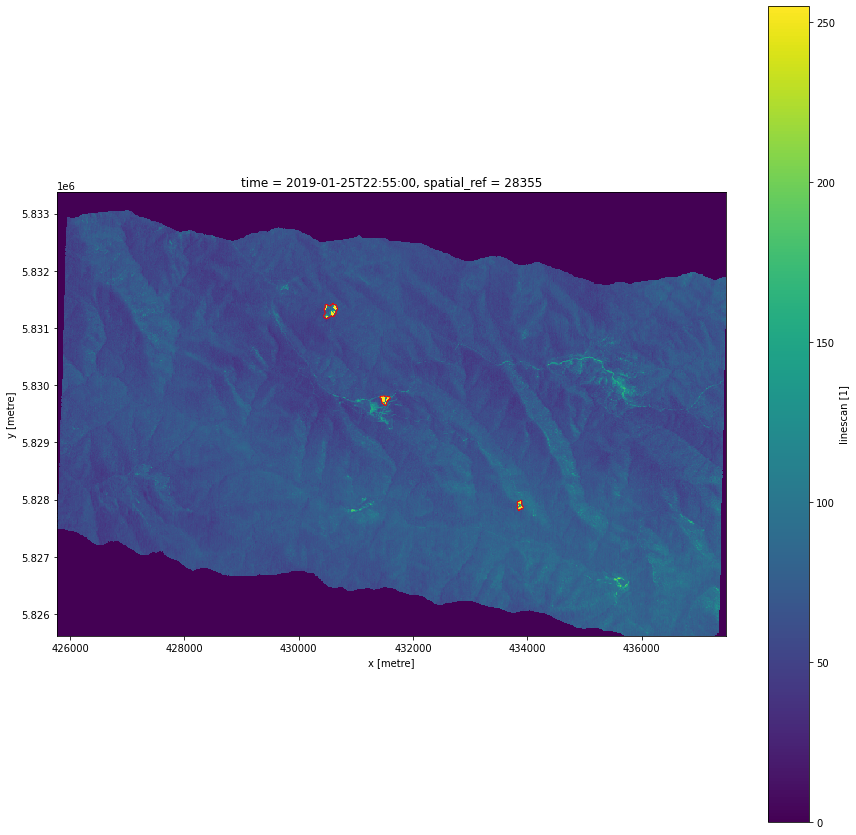

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src.linescan.plot(ax=ax)
ob.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

Currently, our polygons are made from vertices and paths. This is called vector data. By comparison, our linescans are grids of pixel values, called raster data. It may be useful to convert the polygons into a binary raster called a "mask", as many machine learning libraries accept masks as input rather than polygons. We can use the `src` variable to define the extent of the mask that is created from any polygons that intersect with it.

In [63]:
tgt = xr_rasterize(gdf=ob, da=src)
tgt

Rasterizing to match xarray.DataArray dimensions (777, 1171)


<xarray.DataArray (y: 777, x: 1171)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 5.833e+06 5.833e+06 5.833e+06 ... 5.826e+06 5.826e+06
  * x        (x) float64 4.258e+05 4.258e+05 4.258e+05 ... 4.375e+05 4.375e+05
Attributes:
    crs:           epsg:28355
    grid_mapping:  spatial_ref

Note that the `tgt` mask variable contains an array of ones and zeros; ones represent areas inside the polygons and zeroes represent areas outside them.

Text(0.5, 1.0, 'Target: ground truth mask')

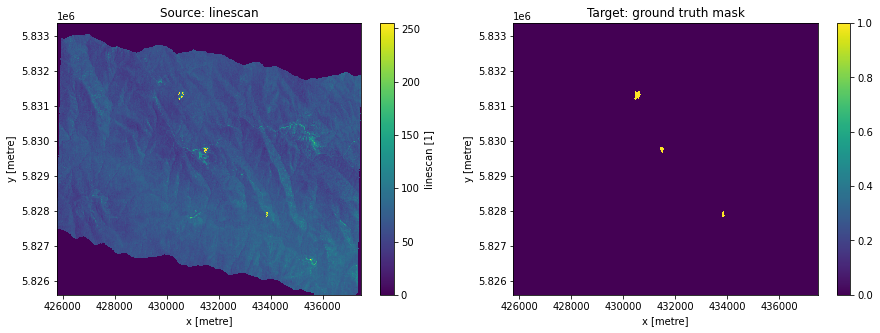

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
src.linescan.plot(ax=ax[0])
ax[0].set_title('Source: linescan')

tgt.plot(ax=ax[1])
ax[1].set_title('Target: ground truth mask')

## Extract fire boundary from raster

Before we can extract meaningful information from the linescan image, we need to clean up noise in the image and make the signal clearer. For example, we could threshold the image to mask the data and remove the noise. You can experiment with different strategies including machine learning and feature engineering to find an optimal process. Further guidance can be found in the [Image analysis in python](Image_analysis_in_python.ipynb) notebook.

In [65]:
threshold = 220
our_mask = src.linescan>threshold

Text(0.5, 1.0, 'Target: ground truth mask')

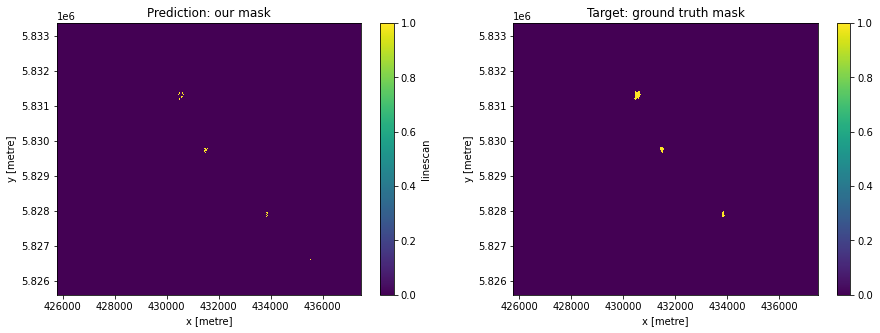

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
our_mask.plot(ax=ax[0])
ax[0].set_title('Prediction: our mask')

tgt.plot(ax=ax[1])
ax[1].set_title('Target: ground truth mask')

## Making a submission
For the five linescans where there is no mask provided, you must first create a mask, and then return one or zero for a specific set of coordinates, where one indicates that coordinate is on fire, and zero indicates it is not.

The "challenge1_test.csv" file provides a list of 1000 coordinates that are required to be classified for each of these five linescans. You can use the filenames to identify the relevant linescan to source your predictions from, or you can use the dateTimeLocal column in combination with the coordinates to load subsets of data directly from the ODC. Note that the coordinates are denoted in the same Coordinate Reference System (CRS) as the linescans and polygons, epsg:28355.

In [67]:
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
print(test.shape)
test.head()

(5000, 5)


,filename,x,y,dateTimeLocal,target
id,,,,,
0,JORDAN_235_P1_201901281204_MGA94_55,436123,5826713,28/01/2019 1:04,NaN
1,JORDAN_235_P1_201901281204_MGA94_55,435924,5828006,28/01/2019 1:04,NaN
2,JORDAN_235_P1_201901281204_MGA94_55,436458,5827661,28/01/2019 1:04,NaN
3,JORDAN_235_P1_201901281204_MGA94_55,436166,5828564,28/01/2019 1:04,NaN
4,JORDAN_235_P1_201901281204_MGA94_55,436283,5826144,28/01/2019 1:04,NaN


We can index into the dataset at particular coordinates to return the value at that address.

In [21]:
# get the coordinates of the centre of the dataset (or any point of interest)
x, y = (our_mask.extent.boundingbox.left + our_mask.extent.boundingbox.width // 2 ,
        our_mask.extent.boundingbox.top - our_mask.extent.boundingbox.height // 2)
print(x, y)

# get the value at those coordinates using sel
centre_value = our_mask.sel(x = x, y = y, method='nearest').values[0]
print(centre_value)

431625.0 5829495.0
False


Now we will iterate over the test set of linescan images, and iterate over the test coordinates required in each image, filling the 'onFire' column of the 'test' dataframe with the results of the masking process we have developed.

In [39]:
fnames = test.filename.unique()
fnames

array(['JORDAN_235_P1_201901281204_MGA94_55',
       'JORDAN_294_P1_201902011150_MGA94_55',
       'WALHALLA_313_P1_201902020733_MGA94_55',
       'WALHALLA_353_P1_201902031625_MGA94_55',
       'MACALISTER91_648_P1_201903070444_MGA94_55'], dtype=object)

In [40]:
threshold = 220
    
for file_stem in fnames:
    
    # load the linescan data
    src = dc.load(product='linescan', label=file_stem, output_crs='epsg:28355', resolution=(-10,10))

    # create a mask using the process we developed earlier. For this example, we will simply threshold each linescans
    mask = src.linescan>threshold
    
    # iterate over the coordinates that are required for testing in the current linescan file
    for idx, ob in test.loc[test.filename==file_stem].iterrows():
        result_tf = mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
        result_10 = int(result_tf == True)
        test.loc[(test.filename==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

In [41]:
test.target.value_counts()

0.0    4927
1.0      73
Name: target, dtype: int64

In [42]:
test.to_csv('my_challenge1_submission.csv', columns = ['target'])
test.head()

,filename,x,y,dateTimeLocal,target
id,,,,,
0,JORDAN_235_P1_201901281204_MGA94_55,436123,5826713,28/01/2019 1:04,0.0
1,JORDAN_235_P1_201901281204_MGA94_55,435924,5828006,28/01/2019 1:04,0.0
2,JORDAN_235_P1_201901281204_MGA94_55,436458,5827661,28/01/2019 1:04,0.0
3,JORDAN_235_P1_201901281204_MGA94_55,436166,5828564,28/01/2019 1:04,0.0
4,JORDAN_235_P1_201901281204_MGA94_55,436283,5826144,28/01/2019 1:04,0.0


Submit your file to the [EY Data Science Platform](https://datascience.ey.com/) for grading.

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question in the [Troubleshooting EY Data Science Program MS Teams Channel](https://teams.microsoft.com/l/channel/19%3a90804a73cb5a4159a60693c41a8820d2%40thread.tacv2/Troubleshooting?groupId=f6acd945-fed9-4db4-bed8-414988473a36&tenantId=5b973f99-77df-4beb-b27d-aa0c70b8482c) or on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2021